In [1]:
import os

os.getcwd()

'C:\\Users\\aibiz\\Documents\\GitHub\\building_security_data\\Jihun'

In [11]:
# conda info --env

In [10]:
# conda env list

In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from selenium.webdriver.support.ui import Select

from tqdm.autonotebook import tqdm

import pickle

C:\Users\USER\AppData\Local\Temp\ipykernel_8404\1803949859.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
url = "https://www.weather.go.kr/plus/land/current/aws_table_popup.jsp"
url

'https://www.weather.go.kr/plus/land/current/aws_table_popup.jsp'

In [4]:
driver = webdriver.Chrome("chromedrive.exe")
driver.get(url)

C:\Users\aibiz\AppData\Local\Temp\ipykernel_12020\297859235.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("chromedrive.exe")


## 관측 간격 설정

In [5]:
driver.switch_to.frame(driver.find_element(By.ID, "menu"))

select_scale = Select(driver.find_element(By.NAME, "db"))
select_60 = select_scale.select_by_index(3)  # 1시간 간격

driver.switch_to.default_content()

## 기간 설정

In [6]:
start_date = datetime(2022, 11, 25, 11, 0, 0)
end_date = datetime(2023, 5, 9, 13, 30, 0)
delta = timedelta(hours=60)

current_date = start_date
date_li = [start_date]
while current_date <= end_date - timedelta(hours=10):
    # 원하는 로직을 수행
    # print(current_date)

    # 다음 반복을 위해 현재 날짜를 업데이트
    current_date += delta
    date_li.append(current_date)

date_li[-1]
# len(date_li)

datetime.datetime(2023, 5, 9, 11, 0)

## 날짜 인덱스 수정 함수

In [7]:
def modified_date(date):
    modified_month = None  # modified_month 변수 초기화
    modified_day = None  # modified_day 변수 초기화

    start_date = date + timedelta(hours=60)

    year = str(start_date.year)
    month = start_date.month - 1
    day = start_date.day - 1
    hour = start_date.hour
    hour = str(hour).zfill(2)  # 시간 포맷을 2자리로 맞춤
    if hour.startswith("0"):
        hour = hour[1:]

    return year, month, day, hour

## 크롤링 함수

In [8]:
def crawling(date, region):
    year, month, day, hour = modified_date(date)
    # 관측  1시간 간격
    driver.switch_to.frame(driver.find_element(By.ID, "menu"))

    select_scale = Select(driver.find_element(By.NAME, "db"))
    select_60 = select_scale.select_by_index(3)  # 1시간 간격

    driver.switch_to.default_content()
    driver.find_element(By.ID, "datecal2").click()
    time.sleep(2)

    select_year = Select(driver.find_element(By.CLASS_NAME, "ui-datepicker-year"))
    select_2022 = select_year.select_by_value(year)

    select_month = Select(driver.find_element(By.CLASS_NAME, "ui-datepicker-month"))
    select_11 = select_month.select_by_index(month)

    select_calendar = driver.find_element(By.CLASS_NAME, "ui-datepicker-calendar")
    select_date = select_calendar.find_elements(By.CLASS_NAME, "ui-state-default")
    select_25 = select_date[day].click()

    select_hour = driver.find_element(By.CLASS_NAME, "ui_tpicker_hour_slider")
    select_hour = Select(
        driver.find_element(
            By.CLASS_NAME, "ui-timepicker-select.ui-state-default.ui-corner-all"
        )
    )
    select_11 = select_hour.select_by_value(hour)

    select_min = driver.find_element(By.CLASS_NAME, "ui_tpicker_minute_slider")
    select_min = Select(
        select_min.find_element(
            By.CLASS_NAME, "ui-timepicker-select.ui-state-default.ui-corner-all"
        )
    )
    select_00 = select_min.select_by_value("0")
    # 완료 버튼
    driver.find_element(
        By.CLASS_NAME,
        "ui-datepicker-close.ui-state-default.ui-priority-primary.ui-corner-all",
    ).click()
    # 선택 버튼
    driver.find_element(By.CLASS_NAME, "btn").click()

    # 지역선택
    driver.switch_to.frame(driver.find_element(By.ID, "disp"))
    driver.switch_to.frame(driver.find_element(By.NAME, "all"))
    td_elements = driver.find_elements(By.TAG_NAME, "td")
    region_li = [td.text for td in td_elements]
    # 지역을 찾은 경우에
    if region in region_li:
        for td in td_elements:
            if td.text == region:
                td.click()
                driver.switch_to.default_content()
                break
    elif region in ["양주", "광진"]:
        if region == "양주":
            region_big = "파주"
        elif region == "광진":
            region_big = "서울"
        for td in td_elements:
            if td.text == region_big:
                td.click()
                driver.switch_to.default_content()
                break
    else:
        print("지역을 못찾았습니다")
        driver.switch_to.default_content()
        return

    driver.switch_to.frame(driver.find_element(By.ID, "disp"))
    driver.switch_to.frame(driver.find_element(By.NAME, "all"))
    driver.switch_to.frame(driver.find_element(By.NAME, "sub"))
    driver.find_element(By.XPATH, f"//img[@alt='{region}']").click()
    driver.switch_to.default_content()

    # 표 frame으로 전환
    driver.switch_to.frame(driver.find_element(By.ID, "disp"))
    driver.switch_to.frame(driver.find_element(By.NAME, "body"))
    table = driver.find_element(By.TAG_NAME, "table")
    rows = table.find_elements(By.TAG_NAME, "tr")
    header_row = rows[0]
    header_cells = header_row.find_elements(By.TAG_NAME, "td")
    columns = [cell.text for cell in header_cells]
    columns = columns[1:18]
    data = []

    # 셀(cell) 선택 및 데이터 추출
    for row in rows[2:]:
        cells = row.find_elements(By.TAG_NAME, "td")
        row_data = []
        for i in range(len(columns)):
            cell_value = cells[i].text if i < len(cells) else None
            row_data.append(cell_value)
        data.append(row_data)

    # 데이터 프레임으로 변환
    df_og = pd.DataFrame(data, columns=columns)
    try:
        variable_col_name = df_og.iloc[0, 0]
        variable_col_name_2 = df_og.iloc[0, 1]
        selected_columns = [
            "강수60",
            "기온",
            f"{variable_col_name}",
            f"{variable_col_name_2}",
        ]
        df = df_og[selected_columns]
        df = df.rename(
            columns={
                f"{variable_col_name}": "습도",
                f"{variable_col_name_2}": "해면기압",
            }
        )
        df = df.replace(" ", np.nan)
        df = df.replace(".", np.nan)  # '.'을 NaN으로 대체
        start_date = date + timedelta(hours=60)
        df["계측시간"] = pd.date_range(start=start_date, periods=len(df), freq="-1H")
        df = df.sort_values(by="계측시간").set_index(["계측시간"])
        df = df.dropna()  # NaN이 있는 행 삭제
        df = df.astype(float)  # 나머지 열을 부동 소수점으로 변환
    except:
        df = None
        pass
    driver.switch_to.default_content()
    return df, df_og

## 지역별 온도 크롤링 > 피클 파일 저장

In [142]:
region_li = ["여수", "광진", "양주"]
for region in region_li:
    merge_df, _ = crawling(date_li[0], region)
    for date in tqdm(date_li[1:]):
        df, df_og = crawling(date, region)
        if df is None:
            print("전처리 오류, 해당 df_og 확인 필요")
            display(df_og)
            break
        merge_df = pd.concat([merge_df, df])
    merge_df = merge_df.drop_duplicates()
    merge_df.name = region

    merge_df.to_pickle(f"../크롤링 온도 자료/{merge_df.name}.pkl")

## 온도 시각화

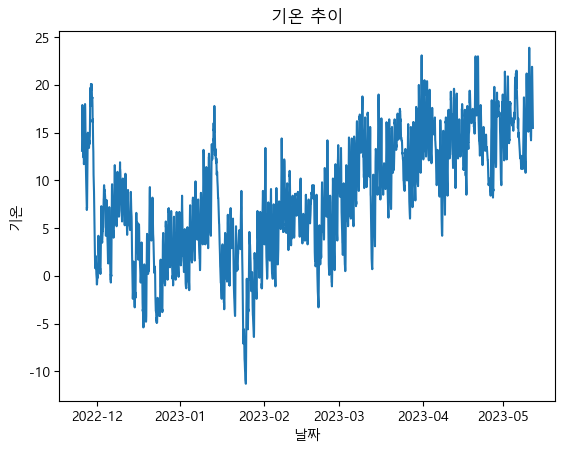

In [137]:
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 플롯 생성
plt.plot(merge_df.index, merge_df["기온"])

# 축과 타이틀 설정
plt.xlabel("날짜")
plt.ylabel("기온")
plt.title("기온 추이")

# 플롯 보여주기
plt.show()